In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style

import hbsir

matplotlib.style.use("bmh")

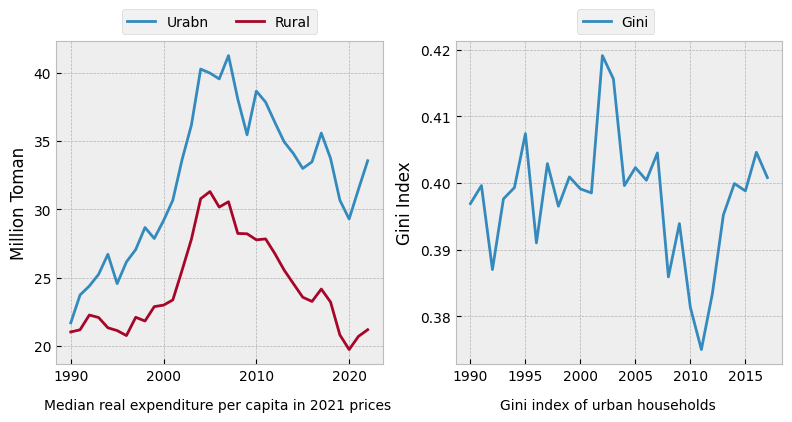

In [2]:
YEARS = range(1369, 1402)
median_expenditure = (
    hbsir.load_table("Total_Expenditure", years=YEARS)
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.adjust_by_cpi)
    .merge(hbsir.load_table("Equivalence_Scale", years=YEARS), on=["Year", "ID"])
    .assign(
        Real_Expenditure =
        lambda df: df.eval(
            "Gross_Expenditure / OECD_Modified / 1e7"
        )
    )
    .groupby(["Year", "Urban_Rural"])["Real_Expenditure"].median()
    .unstack()
    .set_axis(
        pd.Index([year+ 621 for year in YEARS], name="Year"),
        axis="index",
    )
)

gini = (
    hbsir.external_data.load_table("Gini", data_source="CBI")
    .query("1369 <= Year <= 1401")
    .eval("Year = Year + 621")
    .set_index("Year")
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(median_expenditure.index, median_expenditure["Urban"], label="Urabn")
ax1.plot(median_expenditure.index, median_expenditure["Rural"], label="Rural")
ax1.set_ylabel("Million Toman")
ax1.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center', ncols=2)

ax2.plot(gini.index, gini["Gini"], label="Gini")
ax2.set_ylabel("Gini Index")
ax2.legend(bbox_to_anchor=(0.63, 1.12))

fig.text(0.06, -0.03 , "Median real expenditure per capita in 2021 prices")
fig.text(0.63, -0.03 , "Gini index of urban households")

fig.tight_layout(pad=1)

In [3]:
YEARS = range(1388, 1402)

hh_info = hbsir.load_table("household_information", years=YEARS)

members = (
    hbsir.load_table("members_properties", years=YEARS)
    .dropna(subset="Member_Number")
    .assign(Member_Number=lambda df: df["Member_Number"].astype(int))
)

moving_info = pd.Series(
    data = (
        pd.Categorical(
            hh_info["Alternative_Household"]
            .fillna(False)
            .astype(int),
        )
        .rename_categories({0: "not_moved", 1: "moved"})
    ),
    index=pd.MultiIndex.from_frame(hh_info[["Year", "ID"]]),
)

time_differences = (
    hh_info
    .assign(Year = lambda df: df["Year"] + 1)
    .set_index(["Year", "ID"])["Month"]
    .add(12)
    .subtract(
        hh_info
        .set_index(["Year", "ID"])["Month"]
    )
    .dropna()
    .astype(int)
)

time_filter = (10 <= time_differences) & (time_differences <= 14)

In [4]:

def build_columns_tuples(dataframe: pd.DataFrame, columns: list) -> list[tuple]:
    return list(zip(*[dataframe[column] for column in columns]))


def build_columns_series(
        dataframe: pd.DataFrame,
        columns: list,
        index: tuple = ("Year", "ID", "Member_Number")
) -> pd.Series:
    return pd.Series(
        data=build_columns_tuples(dataframe, columns),
        index=pd.MultiIndex.from_frame(dataframe[list(index)])
    )

panel_households = (
    build_columns_series(members, ["Year", "ID"])
    .isin(build_columns_tuples(members.eval("Year = Year + 1"), ["Year", "ID"]))
    .groupby(["Year", "ID"]).all()
)

columns = ["Year", "ID", "Relationship", "Sex", "Age", "Marrital_State"]

lead_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age + 1"),
        ]
    )
    .eval("Year = Year + 1")
)

lead_set = build_columns_tuples(lead_df, columns)
same_members_lead = build_columns_series(members, columns).isin(lead_set)

lag_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age - 1"),
        ]
    )
)

lag_set = build_columns_tuples(lag_df, columns)
same_members_lag = (
    build_columns_series(members.eval("Year = Year + 1"), columns).isin(lag_set)
)

member_filter = (
    (same_members_lead & same_members_lag)
    .groupby(["Year", "ID"]).all()
)

# final_filter = member_filter & time_filter
final_filter = member_filter

In [5]:
real_income = (
    hbsir.load_table("Total_Expenditure", years=YEARS)
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.adjust_by_cpi)
    .merge(hbsir.load_table("Equivalence_Scale", years=YEARS), on=["Year", "ID"])
    .assign(
        Real_Expenditure =
        lambda df: df.eval("Gross_Expenditure / OECD_Modified / 1e7")
    )
    .set_index(["Year", "ID"])
)

<Axes: xlabel='Year', ylabel='Mobility (%)'>

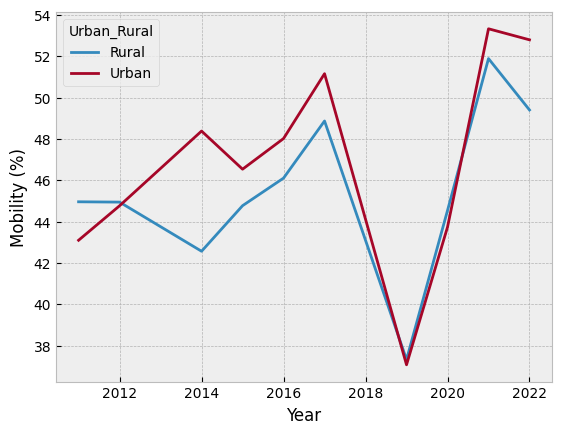

In [6]:
year_id = pd.MultiIndex.from_frame(
    final_filter.to_frame()
    .loc[final_filter]
    .reset_index()
    .pipe(
        lambda df:
        pd.concat(
            [df, df.eval("Year = Year - 1")],
            ignore_index=True
        )
    )
    .loc[:, ["Year", "ID"]]
    .drop_duplicates()
)

weights = (
    hbsir.load_table("Weights", years=YEARS)
    .set_index(["Year", "ID"])
    .loc[year_id]
    .unstack("Year")
)

aiim = (
    real_income
    .loc[year_id, ["Urban_Rural", "Real_Expenditure"]]
    .set_index("Urban_Rural", append=True)
    .unstack("Year")
    .sort_index(axis="columns")
    .pipe(lambda df: df.shift(axis="columns").subtract(df).multiply(-1))
    .droplevel(0, axis="columns")
    .drop(columns=[1389])
    .groupby("Urban_Rural").apply(
        lambda df: df.ge(0).mul(weights).sum().div(df.notna().mul(weights).sum()).mul(100)
    )
    .droplevel(0, axis="columns")
    .transpose()
    .dropna()
    .pipe(lambda df: df.set_axis(df.index + 621, axis="index"))
)

aiim.plot(ylabel="Mobility (%)")